In [63]:
import os
from collections import defaultdict
from datetime import datetime
import copy

from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib 

matplotlib.rcParams.update({'font.size': 15})
%matplotlib inline

import plotly
import plotly.graph_objs as pgo

from nxplot_3d import get_trace_nodes_3D_legend
from nxplot_3d import get_trace_edges_3D
from nxplot_3d import plot_3D

from export_import import export_data
from export_import import read_data

from export_vr import export_data_vr

from csv_to_network import get_graph

In [6]:
path= '../data/dynamic/'
file_names =  sorted(os.listdir(path), key=lambda x: datetime.strptime(x, '%Y-%m.csv'))
data = pd.DataFrame(columns=['package', 'requirement', 'time'])

for i, fname in enumerate(file_names):
    dframe_load = pd.read_csv(path+ fname, sep='|', keep_default_na=False)
    dframe_load = dframe_load.assign(time=[fname[:-4] for _ in range(len(dframe_load))])
    data = pd.concat([data, dframe_load], ignore_index=True)
    

In [7]:
class TDiGraph(nx.DiGraph):
    def __init__(self, all_edges):

        self.t = 0
        
        self.all_edges = all_edges
        self.all_nodes = all_edges.drop_duplicates(subset=self.all_edges.keys()[0], ignore_index=True)
        
        self.time_edges = self.all_edges['time']
        self.time_nodes = self.all_nodes['time']
        self.time_steps = sorted(list(set(self.time_nodes)), key=lambda x: datetime.strptime(x, '%Y-%m'))
        
        super(TDiGraph, self).__init__()
    
    def __str__(self):
        return f'TDiGraph with {self.number_of_nodes()} nodes and {self.number_of_edges()} edges at time {self.t}'
    
    def __repr__(self):
        return 'time extention of networkx.classes.digraph.DiGraph'
        
    def forward(self):
        if self.t <= len(self.time_steps):
            self.add_edges_from(zip(self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,0],\
                                       self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,1]))
            self.remove_nodes_from([''])
            self.t += 1
        else:
            raise GeneratorError(f'Max t={len(self.time_steps) + 1} reached')
    
    def backward(self):
        if self.t != 0:
            self.t -= 1
            self.remove_edges_from(zip(self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,0],\
                                       self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,1]))
            self.remove_nodes_from([''])
        else:
            raise GeneratorError('Time t=0 reached')
    
    def to(self, time):
        if self.t < time:
            # add nodes
            pass
        elif self.t > time:
            #remove nodes
            pass
        elif self.t == time:
            pass
        


In [8]:
def tdg_draw(TDG, posDG3D, node_color, node_degree, chosen_nodes=[] ,fname=None, auto_open=True, path='../plots/dynamic/'):
    max_deg = max(TDG.degree(), key=lambda x: x[1])[1]
    if max_deg == 0:
        max_deg = 1
    if fname == None:
        fname = str(TDG.time_steps[TDG.t])
        
    export_data(TDG, posDG3D, node_color, node_alpha, chosen_nodes,\
                path='../nodes_edges/dynamic/',\
                step=TDG.t)
    
    G, d_hoverinfo, d_nodecolors, d_nodesize, posG3D = read_data(f'../nodes_edges/dynamic/nodes_{TDG.t}.csv',
                                                                 f'../nodes_edges/dynamic/edges_{TDG.t}.csv')
    node_trace = get_trace_nodes_3D_legend(posG3D, d_hoverinfo, d_nodecolors, d_nodesize)
    edge_trace = get_trace_edges_3D(G, posG3D, color = '#C7C7C7', opac = 0.2, linewidth=0.5)
    data = [*node_trace, edge_trace]
    plot_3D(data, path=path, fname=fname, scheme='dark', auto_open=auto_open)

def get_color_alpha(G):
    deg = dict(G.degree())
    s_deg = list(set(deg.values()))
    cmap = cm.get_cmap('gray', len(s_deg))
    rgb_alpha = cmap(np.arange(0, cmap.N))
    
    node_alpha = {node: 100/np.log(max(deg.values())) * np.log(L, where=L>0) for node, L in dict(G.in_degree).items()}
    node_color = {node: rgb_alpha[s_deg.index(degree)] for  node, degree in deg.items()}
    return node_color, node_alpha

def get_growth(TDG, k_i_t:dict):
    add_degrees = TDG.in_degree
    k_i_t.update({node: [*k_i_t[node], int(deg)] for node, deg in add_degrees})
    return k_i_t

# Growth Exponent

In [10]:
TDG = TDiGraph(data)
k_i_t = {node: [] for node in TDG.all_nodes.iloc[:,0]}
for i in range(len(TDG.time_steps)):
    TDG.forward()
    get_growth(TDG, k_i_t)

In [11]:
k_i_t = sorted(list(k_i_t.items()), key=lambda x: max(x[1]), reverse=True)

/home/miksa/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/miksa/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/miksa/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_110481/3121459279.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(years[-7:], rotation='vertical', fontsize=10)


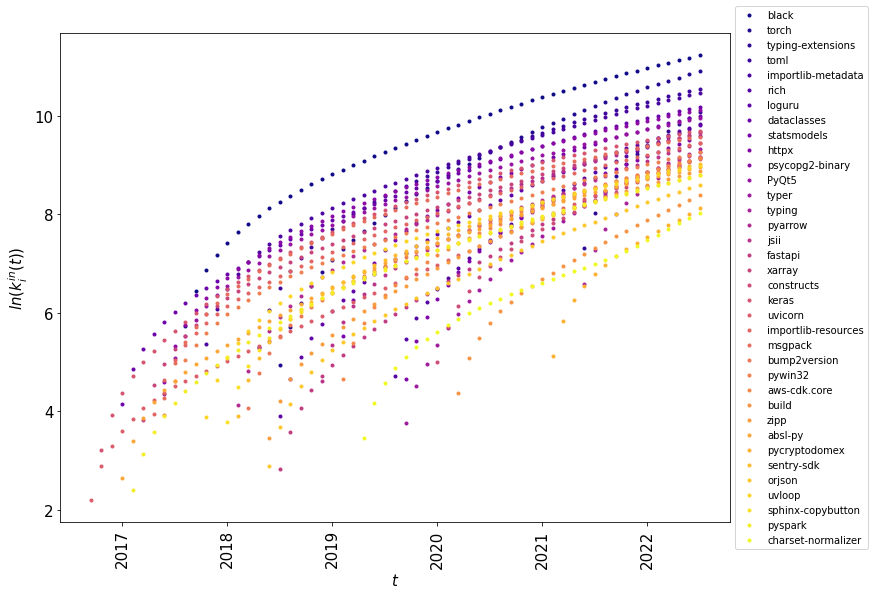

In [97]:
def fit_lin(x, β, B):
    return β * x + B 

time_steps = len(TDG.time_steps)
years = sorted(list(set([date[:4] for date in TDG.time_steps])), key=lambda x: datetime.strptime(x, '%Y'))
fig, ax = plt.subplots(1, 1, figsize=[12, 9])
cmap = cm.get_cmap('tab10').colors
j=0
β_i = {}
variance = {}

for node, k_i in [k_i_t[i] for i in range(len(k_i_t)) if max(k_i_t[i][1]) > 50 and len(k_i_t[i][1]) < 12*5]:
    try:
        time_creation = time_steps - len(k_i)
        time_seq = np.arange(time_creation, time_steps)
        cum_log_k_i = np.log(np.cumsum(k_i), where=(np.array(k_i)>0))
        β, B, r, p, std_err = linregress(time_seq, cum_log_k_i)
        if r**2 < 0.90 or std_err > 0.5:
            continue
        else:
            β_i[node] =  β
            if j < 300:
                ax.plot(time_seq, cum_log_k_i, '.', label=node, color=cm.get_cmap('plasma', 36).colors[j])
                j+=1
    except:
        continue
    

#ax.set_xticks([(time_steps)/len(years)*i for i in range(len(years[:]))])
ax.set_xticklabels(years[-7:], rotation='vertical', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel(r'$t$', fontsize=15)
ax.set_ylabel(r'$ln(k^{in}_i(t))$', fontsize=15)
fig.savefig('../tex_stuff/pres/pics/deg_2016_growth.png', dpi=300)

In [98]:
print(len(β_i.items()))

196


## Nodes not created before 2016 with best node fitness

/tmp/ipykernel_110481/1242086162.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(years[-7:], rotation='vertical', fontsize=10)


Text(0, 0.5, '$ln(k^{in}_i(t))$')

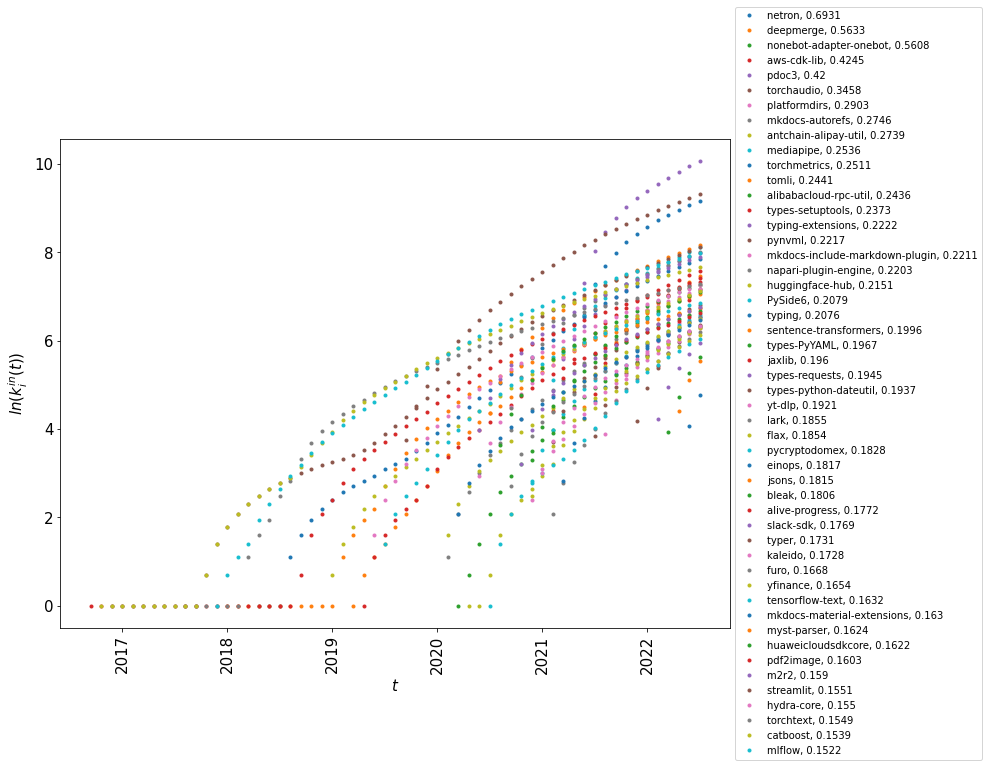

In [99]:
fig, ax = plt.subplots(1, 1, figsize=[12, 9])
for node, fitness in sorted(list(β_i.items()), key=lambda x: x[1], reverse=True)[:50]:
    k_i = dict(k_i_t)[node]
    cum_log_k_i = np.log(np.cumsum(k_i), where=(np.array(k_i)>0))
    time_creation = time_steps - len(k_i)
    time_seq = np.arange(time_creation, time_steps)
    ax.plot(time_seq, cum_log_k_i, '.', label=f'{node}, {round(fitness, 4)}')

ax.set_xticklabels(years[-7:], rotation='vertical', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel(r'$t$', fontsize=15)
ax.set_ylabel(r'$ln(k^{in}_i(t))$', fontsize=15)

/tmp/ipykernel_342492/4149663712.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(ϱ_η[1][1:]), np.log(ϱ_η[0]/sum(ϱ_η[0])), 'o')


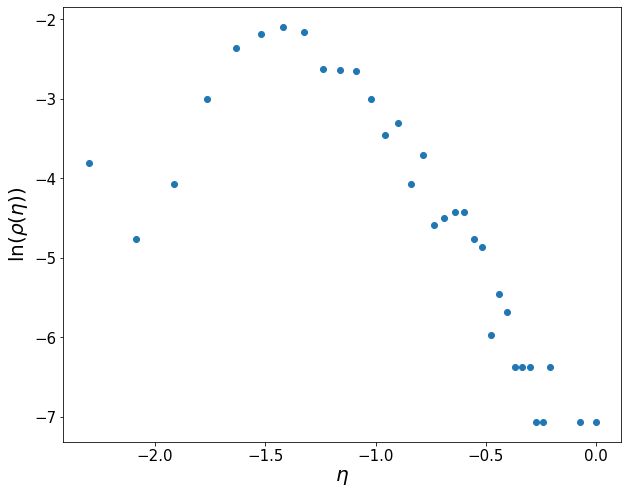

In [8]:
lβ = list(β_i.values())
ϱ_η = np.histogram(lβ/max(lβ), bins='auto')
fig, ax = plt.subplots(1, 1, figsize=[10, 8])
ax.plot(np.log(ϱ_η[1][1:]), np.log(ϱ_η[0]/sum(ϱ_η[0])), 'o')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel(r'$\ln(\rho(\eta))$', fontsize=20)
ax.set_xlabel(r'$\eta$', fontsize=20)
#ax.legend(loc='best', fontsize=20)
fig.savefig('../tex_stuff/pres/pics/fitness.png', dpi=300)

# Node Growth

In [5]:
TDG = TDiGraph(data)
n_nodes = []
k_max = []
for i in range(len(TDG.time_steps)-1):
    TDG.forward()
    n_nodes.append(TDG.number_of_nodes())
    k_max.append(max(list(TDG.degree()), key=lambda x:x [1])[1])

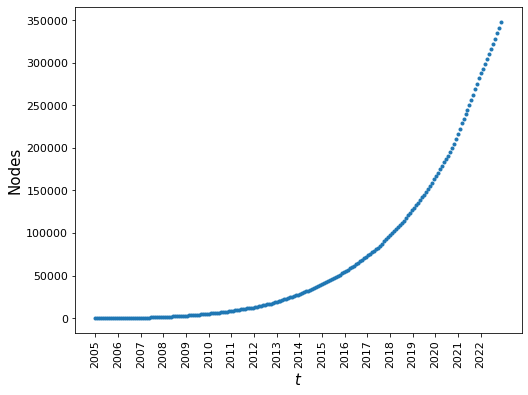

In [19]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
ax.plot(n_nodes, '.')
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticks([len(n_nodes)/len(years)*i for i in range(len(years))])
ax.set_xticklabels(years, rotation='vertical')
ax.set_xlabel(r'$t$', fontsize=15)
ax.set_ylabel(r'Nodes', fontsize=15)
fig.savefig('../tex_stuff/pres/pics/deg_growth.png', dpi=300)

# 3D Light ray layout

In [50]:
def uniform_in_circle(R):
    ϕ = np.random.uniform(0, R) * 2 * np.pi
    r = np.sqrt(np.random.uniform(0, R))
    x = r * np.cos(ϕ)
    y = r * np.sin(ϕ)
    return x, y

def ray_layout(G, remove_nodes=10):
    degree = list(dict(G.degree).values())
    dist, layers = np.histogram(degree, bins=np.logspace(np.log(1), np.log(max(degree)), 30))
    posDG3D = {}
    for n in G.nodes():
        for i in range(len(layers)-1):
            if G.degree(n) <= layers[i+1]:
                x, y = uniform_in_circle(dist[i]/2)
                z = np.sqrt(i) 
                posDG3D[n] = [x, y, z]
                break
    return posDG3D

def ray_layout_simple(G):
    degree = list(dict(G.degree).values())
    dist, layers = np.histogram(degree, bins='sqrt')
    posDG3D = {}
    for n in G.nodes():
        for i in range(len(layers)-1):
            if G.degree(n) <= layers[i+1]:
                x, y = uniform_in_circle(dist[i]/2)
                z = np.sqrt(i) 
                posDG3D[n] = [x, y, z]
                break
    return posDG3D

In [18]:
TDG = TDiGraph(data)
for i in range(len(TDG.time_steps)):
    tDG.forward() 

In [13]:
remove_nodes = 10
posDG3D = ray_layout(TDG, remove_nodes=remove_nodes)
TDG.remove_nodes_from([node for node, degree in TDG.in_degree if degree < remove_nodes])
node_alpha = {node: 100 for node in TDG.nodes()}
node_color = {node: [1, 1, 1] for node in TDG.nodes()}
chosen_nodes = list(β_i.keys())
tdg_draw(TDG, posDG3D, node_color, node_alpha, chosen_nodes ,fname='sqrt')

# Configuration for VR (exporting data)

In [58]:
TDG = TDiGraph(data)
for i in range(len(TDG.time_steps)):
    TDG.forward()

C_TDG = copy.deepcopy(TDG)
posDG3D = ray_layout(C_TDG)
node_alpha = {node: 100 for node in C_TDG.nodes()}
node_color = {node: [1, 1, 1] for node in C_TDG.nodes()}

TDG.remove_nodes_from([node for node, degree in TDG.in_degree if degree < 10])
chosen_nodes = list(β_i.keys())
longest_living_node = max(chosen_nodes, key=lambda x: len(x))

date_current = data['time'].iloc[-1]
date_creation = data[data['package'] == longest_living_node]['time'].iloc[0]
T_0 =  (int(date_current[:4]) - int(date_creation[:4]))*12 \
                +int(date_current.split('-')[1]) - int(date_creation.split('-')[1])  - 1

export_data_vr(TDG, posDG3D, chosen_nodes, path='../nodes_edges/vr/', step=TDG.time_steps[TDG.t-1])
for i in range(T_0):
    C_TDG.backward()
    TDG.backward()
    if i%9 == 0:
        posDG3D = ray_layout(C_TDG)
        export_data_vr(TDG, posDG3D, chosen_nodes, path='../nodes_edges/vr/', step=TDG.time_steps[TDG.t-1])